In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score, median_absolute_error
import warnings
import seaborn as sns

from computage.utils.data_utils import download_meta, download_dataset
from computage.utils.nan_utils import EN_nan_row_predict,introduce_nans

from computage.models_library.model import LinearMethylationModel

import pandas as pd
import gzip

In [3]:
%reload_ext autoreload

# loading + preprocessing

In [4]:
# data = pd.read_csv('full_blood_HC.csv')
# data
import os
import glob

#import reader
from multiprocessing import Pool

def read_psv_all (file_name):
    return pd.read_csv(file_name,
                       #delimiter='',  # change this as needed                              
                       low_memory=False, index_col = ['Unnamed: 0']
                      ) 

pool = Pool(processes=3) # can change 3 to number of processors you want to utilize
data = read_psv_all('full_blood_HC.csv')
data.head()

,cg13869341,cg14008030,cg12045430,cg20826792,cg00381604,cg20253340,cg21870274,cg03130891,cg24335620,cg16162899,...,cg27356438,cg27409364,cg27425675,cg27443050,cg27460755,cg27476329,cg27513764,cg27530424,cg27585441,cg27657249
GSM1443658,0.850345,0.571662,0.115101,0.217371,0.136810,0.699549,0.747217,0.107723,0.766730,0.813303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443800,0.821636,0.506415,0.138980,0.212379,0.090243,0.586473,0.747264,0.233739,0.792255,0.808847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443272,0.802247,0.518845,0.151033,0.288431,0.107367,0.618184,0.795986,0.129477,0.735356,0.828617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443250,0.851498,0.601998,0.104490,0.188970,0.107187,0.731727,0.749568,0.221319,0.778124,0.832554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443266,0.824495,0.608025,0.108236,0.192101,0.097375,0.556048,0.714904,0.249572,0.767942,0.806314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.shape

(1079, 487177)

In [6]:
meta = pd.read_csv('full_blood_HC_meta.csv',index_col = ['Unnamed: 0'])
meta.shape

(1079, 59)

In [7]:
meta

,Unnamed: 0.1,Title,Tissue,CellType,Gender,Age,Condition,_ConditionSubtype,Platform,SourceGSE,...,_DNAmAge,Condition_SmokingStatus,Ethnicity,_BrodmannArea,_H_in,_W_lb,_ConditionAnemia,_SmokingStatus,_AlcoholStatus,_TcellsES
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
GSM1443250,0,NaN,Blood,Whole blood,F,79.0,HC,NaN,GPL13534,GSE59685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443266,1,NaN,Blood,Whole blood,F,90.0,HC,NaN,GPL13534,GSE59685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443272,2,NaN,Blood,Whole blood,M,78.0,HC,NaN,GPL13534,GSE59685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443658,3,NaN,Blood,Whole blood,F,84.0,HC,NaN,GPL13534,GSE59685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1443796,4,NaN,Blood,Whole blood,M,76.0,HC,NaN,GPL13534,GSE59685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1354388,334,101247,Blood,CD14+,NaN,52.0,HC,NaN,GPL13534,GSE56046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011649
GSM1354392,335,101251,Blood,CD14+,NaN,45.0,HC,NaN,GPL13534,GSE56046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025156
GSM1354399,336,101258,Blood,CD14+,NaN,55.0,HC,NaN,GPL13534,GSE56046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000217


In [8]:
y = pd.DataFrame(meta['Age'])
y = y.rename(columns={'Age': 'age'})
y

,age
Unnamed: 0,
GSM1443250,79.0
GSM1443266,90.0
GSM1443272,78.0
GSM1443658,84.0
GSM1443796,76.0
...,...
GSM1354388,52.0
GSM1354392,45.0
GSM1354399,55.0


In [9]:
y.isna().sum()

age    1
dtype: int64

In [10]:
y[y['age'].isnull()].index.tolist()

['GSM796696']

In [11]:
data.loc['GSM796696']

cg13869341    0.85448
cg14008030    0.50837
cg12045430    0.07106
cg20826792    0.14338
cg00381604    0.05724
               ...   
cg27476329        NaN
cg27513764        NaN
cg27530424        NaN
cg27585441        NaN
cg27657249        NaN
Name: GSM796696, Length: 487177, dtype: float64

In [12]:

data = data.drop(y[y['age'].isnull()].index.tolist())
y = y.dropna()

In [13]:
meta[meta['Condition']!='HC']
# в этом датасете все здоровые

,Unnamed: 0.1,Title,Tissue,CellType,Gender,Age,Condition,_ConditionSubtype,Platform,SourceGSE,...,_DNAmAge,Condition_SmokingStatus,Ethnicity,_BrodmannArea,_H_in,_W_lb,_ConditionAnemia,_SmokingStatus,_AlcoholStatus,_TcellsES
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,


In [14]:
#percents = list(map(lambda element:str(round(element*100)), nan_pct))

In [15]:
nan_pct = np.linspace(0, 0.9, 19)
def medae_r2(X,y,model):
    #nan_pct = [0.1]
    X_test = X.reindex(columns=model.features)
    y_test = y

    mae_uie = []
    r2_uie = []
    

    for p in nan_pct:
        X_nan = introduce_nans(X_test, p)
        #X_nan = X_nas
        y_pred_test = model.predict(X_nan)
        
        
        
        mae_uie.append(median_absolute_error(y_test, y_pred_test))
        r2_uie.append(r2_score(y_test, y_pred_test))
    return mae_uie, r2_uie  

def medae_r2_pred(X,y,model):
    #nan_pct = [0.1]
    X_test = X.reindex(columns=model.features)
    y_test = y

    mae_uie = []
    r2_uie = []

    pred_list = []

    for p in nan_pct:
        X_nan = introduce_nans(X_test, p)
        #X_nan = X_nas
        y_pred_test = model.predict(X_nan)
        
        
        pred_list.append(y_pred_test)
        mae_uie.append(median_absolute_error(y_test, y_pred_test))
        r2_uie.append(r2_score(y_test, y_pred_test))
    pred_matrix = pd.concat(pred_list, axis=1)
    pred_matrix.columns=percents

    return mae_uie, r2_uie, pred_matrix 

In [16]:
mname='phenoage2018'
model_1 = LinearMethylationModel(name=mname)
modelX_w = data.reindex(columns=model_1.features)
percent_missing = modelX_w.isnull().sum().sum() / (modelX_w.shape[0]*modelX_w.shape[1])
print(f'already missed = {round(percent_missing,2)} percent')

mae_0, r2_0= medae_r2(data, y, model_1)
mae_avg, r2_avg = medae_r2(data, y, LinearMethylationModel(name=mname, imputation='average'))
mae_ses, r2_ses = medae_r2(data, y, LinearMethylationModel(name=mname, imputation="sesame_450k"))
#'sesame_450k'

already missed = 0.0 percent


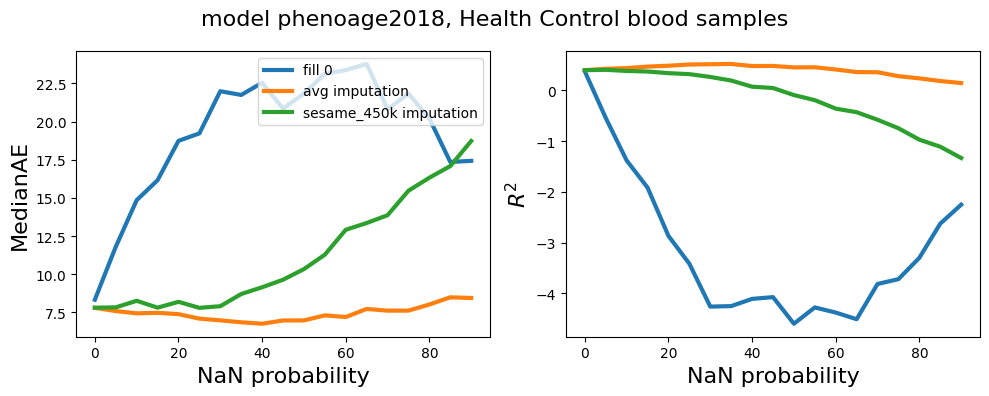

In [17]:
if True:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f'model {mname}, Health Control blood samples', fontsize=16)
    ax[0].plot(nan_pct*100, mae_0, lw=3, label='fill 0')
    ax[0].plot(nan_pct*100, mae_avg, lw =3, label = 'avg imputation')
    ax[0].plot(nan_pct*100, mae_ses, lw =3, label = 'sesame_450k imputation')
    ax[1].plot(nan_pct*100, r2_0, lw=3)
    ax[1].plot(nan_pct*100, r2_avg, lw = 3)
    ax[1].plot(nan_pct*100, r2_ses, lw = 3)


    ax[0].set_xlabel('NaN probability', fontsize=16)
    ax[1].set_xlabel('NaN probability', fontsize=16)
    ax[0].set_ylabel('MedianAE', fontsize=16)
    ax[1].set_ylabel('$R^2$', fontsize=16)
    ax[0].legend(fontsize=10, loc='upper right')
    #ax[1].set_ylim([-0.5, 1.0])
    plt.tight_layout()

    plt.savefig(f'figures/{mname}.png')
    plt.show()

# Plot with all linear blood models

In [18]:
def plot_imputation(mname):
    model_1 = LinearMethylationModel(name=mname)
    modelX_w = data.reindex(columns=model_1.features)
    percent_missing = modelX_w.isnull().sum().sum() / (modelX_w.shape[0]*modelX_w.shape[1])
    print(f'already missed = {round(percent_missing,2)} percent')

    mae_0, r2_0= medae_r2(data, y, LinearMethylationModel(name=mname))
    mae_avg, r2_avg = medae_r2(data, y, LinearMethylationModel(name=mname, imputation='average'))
    mae_ses, r2_ses = medae_r2(data, y, LinearMethylationModel(name=mname, imputation="sesame_450k"))




    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f'model {mname}, Health Control blood samples', fontsize=16)
    ax[0].plot(nan_pct*100, mae_0, lw=3, label='fill 0')
    ax[0].plot(nan_pct*100, mae_avg, lw =3, label = 'avg imputation')
    ax[0].plot(nan_pct*100, mae_ses, lw =3, label = 'sesame_450k imputation')
    ax[1].plot(nan_pct*100, r2_0, lw=3)
    ax[1].plot(nan_pct*100, r2_avg, lw = 3)
    ax[1].plot(nan_pct*100, r2_ses, lw = 3)


    ax[0].set_xlabel('NaN probability', fontsize=16)
    ax[1].set_xlabel('NaN probability', fontsize=16)
    ax[0].set_ylabel('MedianAE', fontsize=16)
    ax[1].set_ylabel('$R^2$', fontsize=16)
    ax[0].legend(fontsize=10, loc='upper right')
    #ax[1].set_ylim([-0.5, 1.0])
    plt.tight_layout()

    plt.savefig(f'figures/{mname}.png')
    plt.show()

hrsinchphenoage
already missed = 0.04 percent


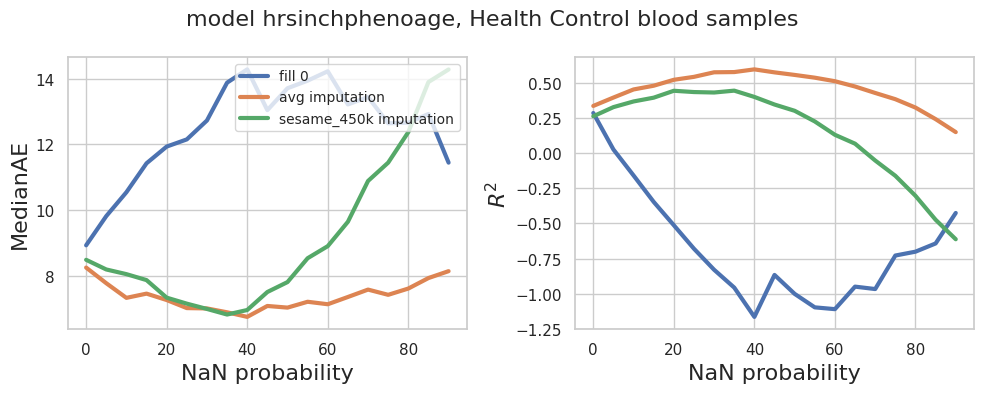

lin2016blood_99cpgs
already missed = 0.0 percent


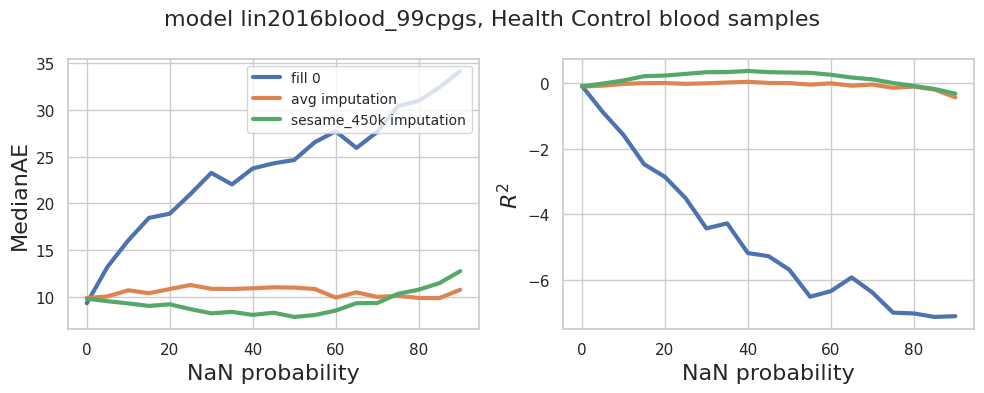

yingdamage
already missed = 0.04 percent


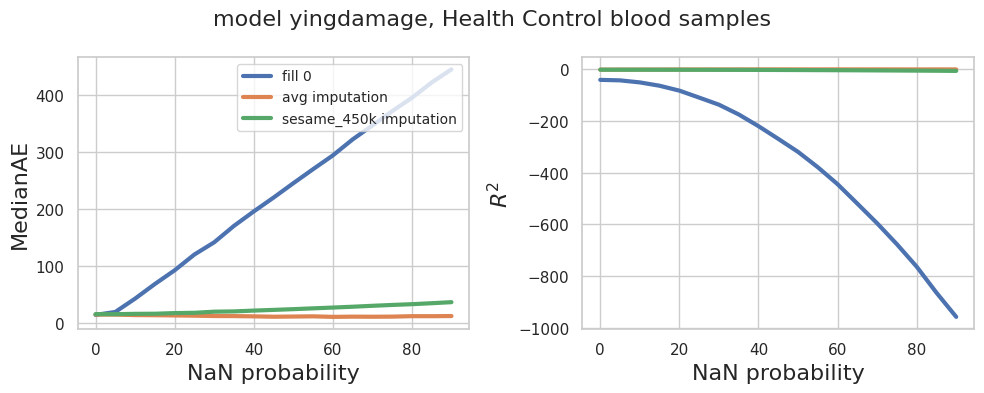

yingadaptage
already missed = 0.04 percent


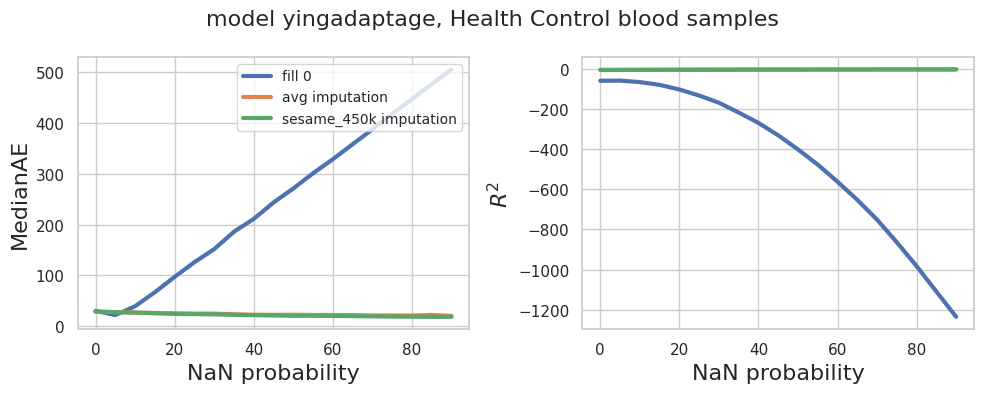

hannum2013blood
already missed = 0.04 percent


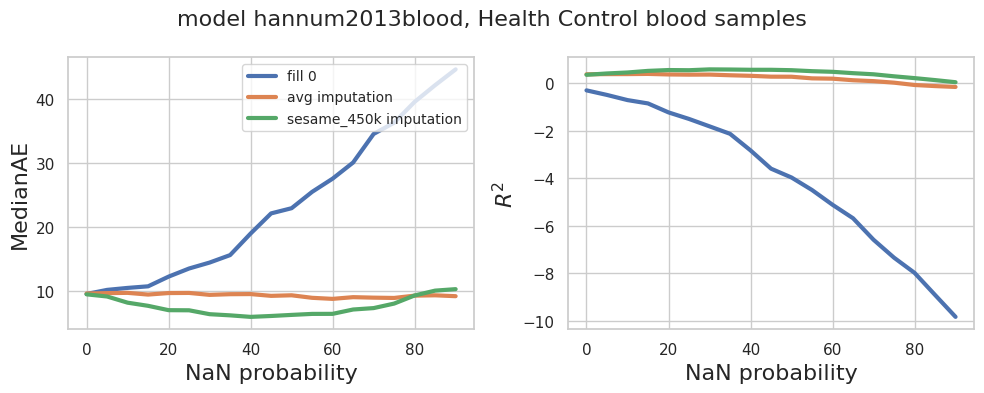

yingcausage
already missed = 0.04 percent


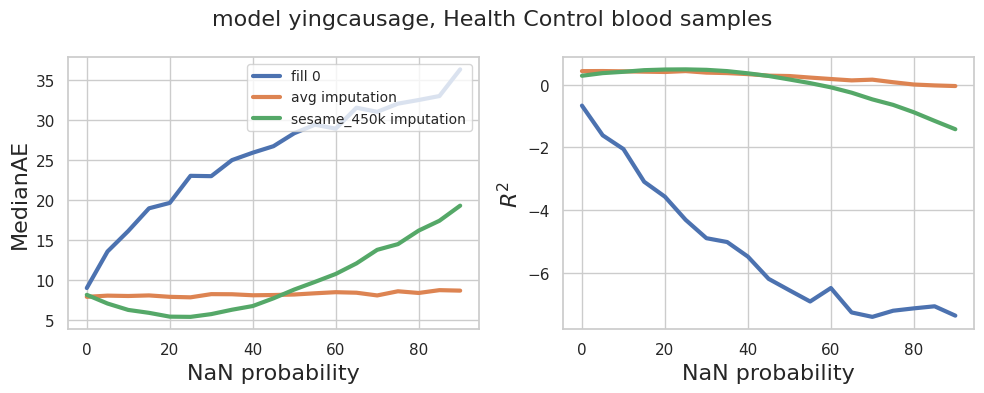

horvath2018
already missed = 0.03 percent


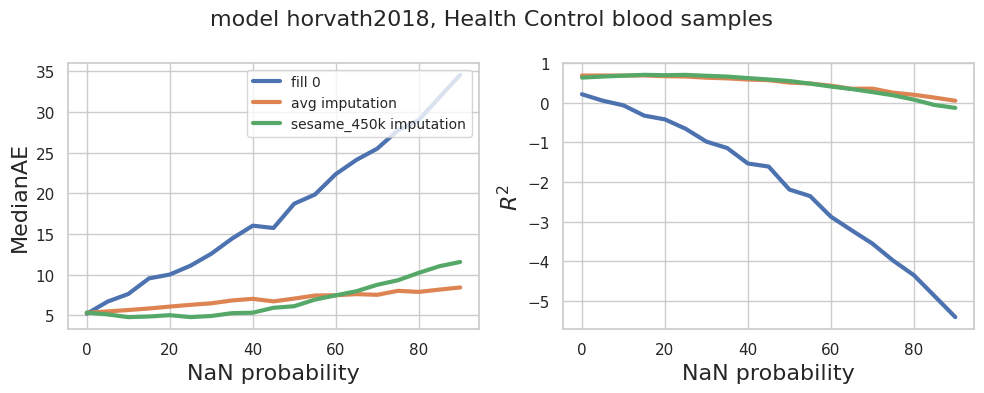

vidal-bralo2016blood
already missed = 0.0 percent


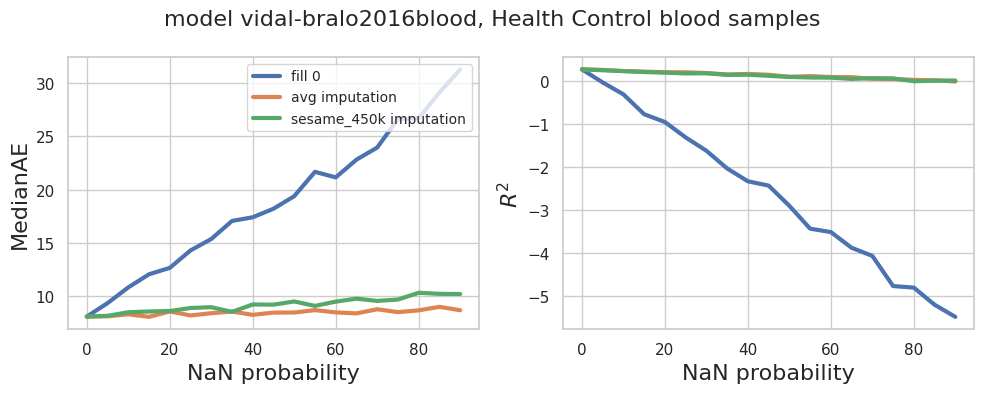

lin2016blood_3cpgs
already missed = 0.0 percent


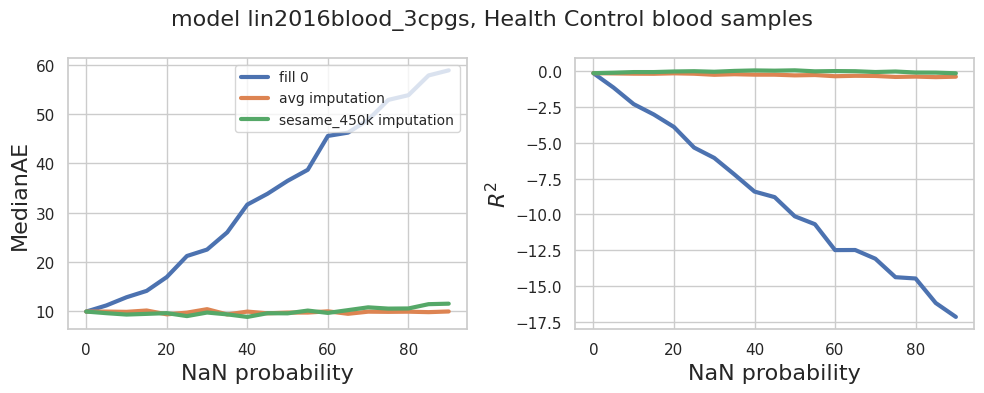

zhangenclock2019
already missed = 0.04 percent


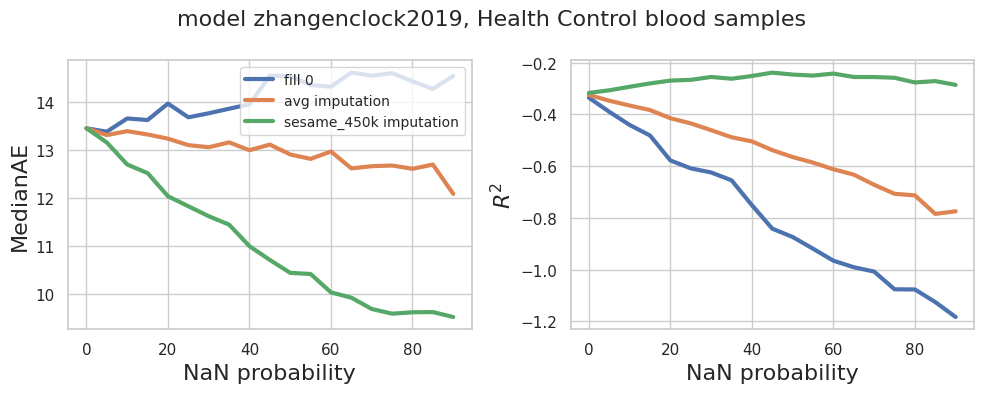

phenoage2018
already missed = 0.0 percent


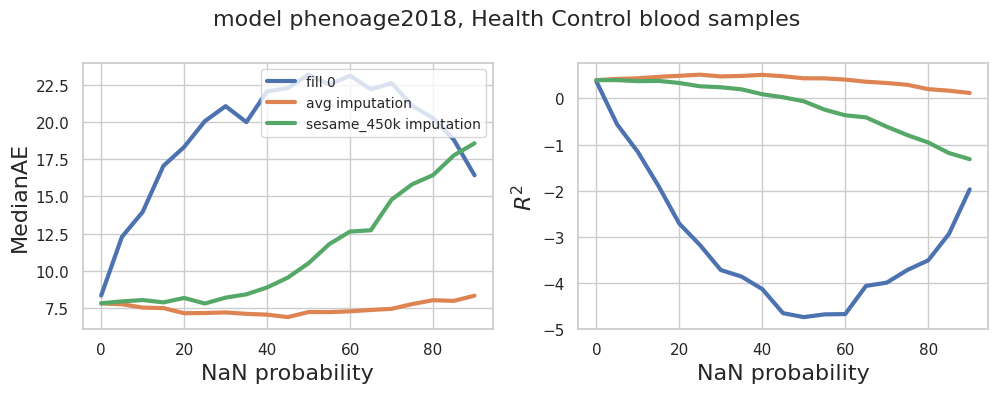

dec2023encen40
already missed = 0.03 percent


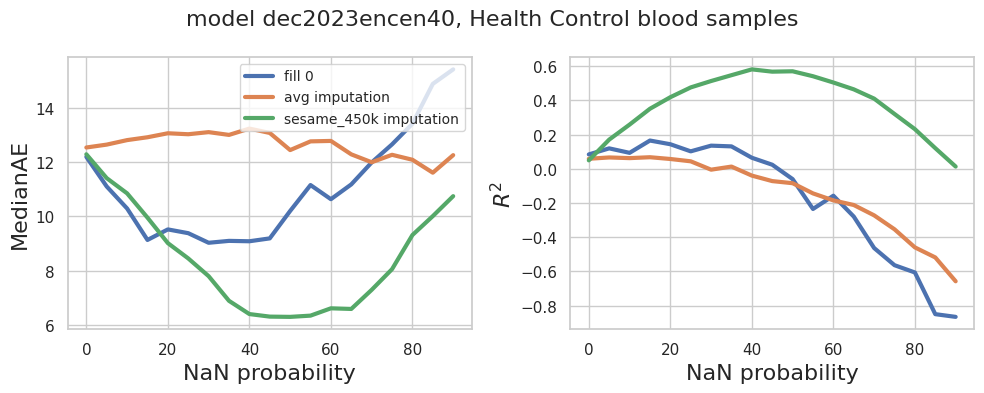

horvath2018
already missed = 0.03 percent


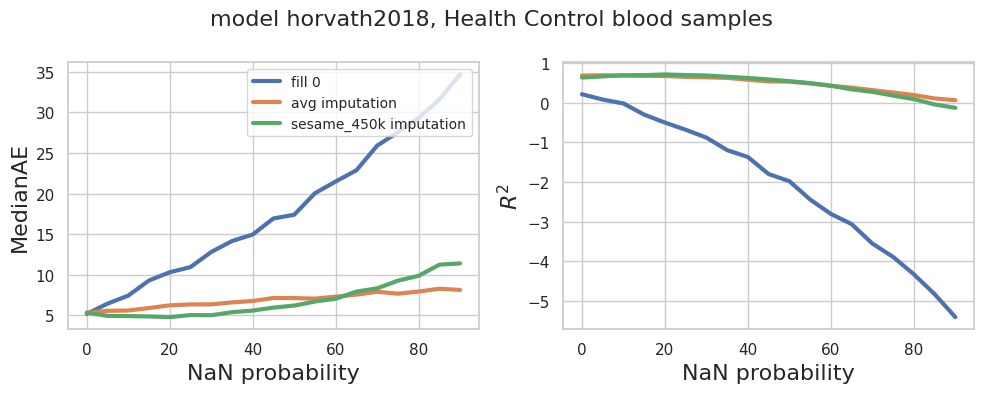

horvath2013_shrunken
already missed = 0.0 percent


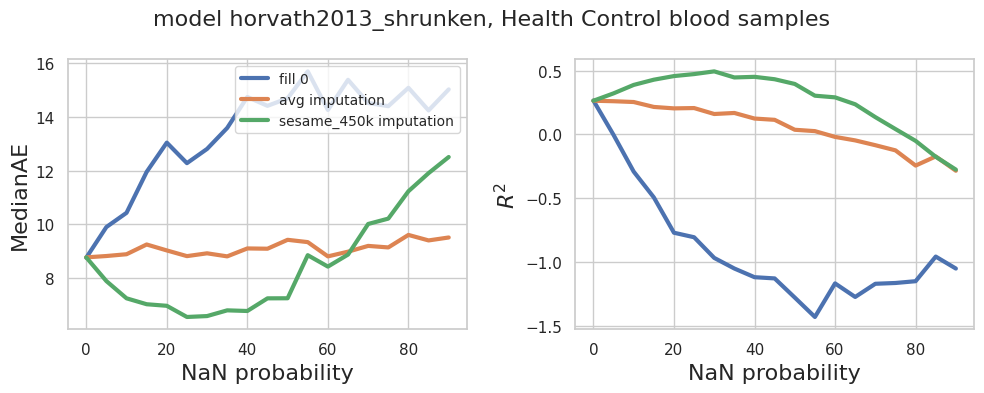

horvath2013
already missed = 0.0 percent


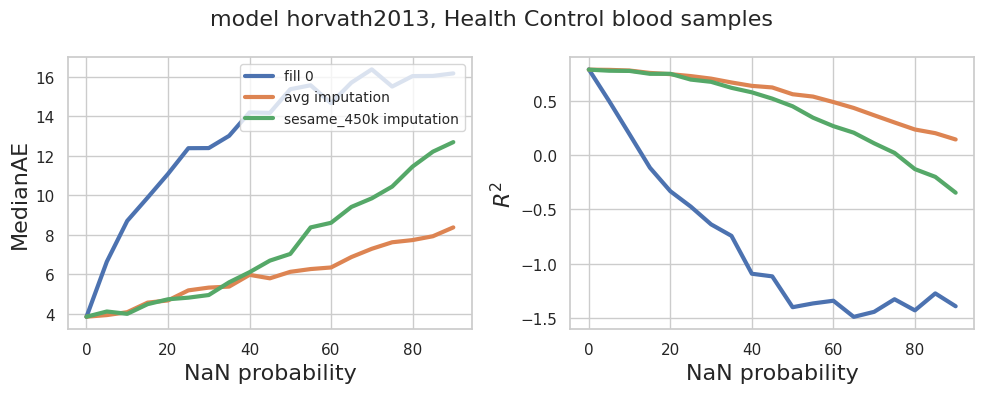

han2020blood
already missed = 0.04 percent


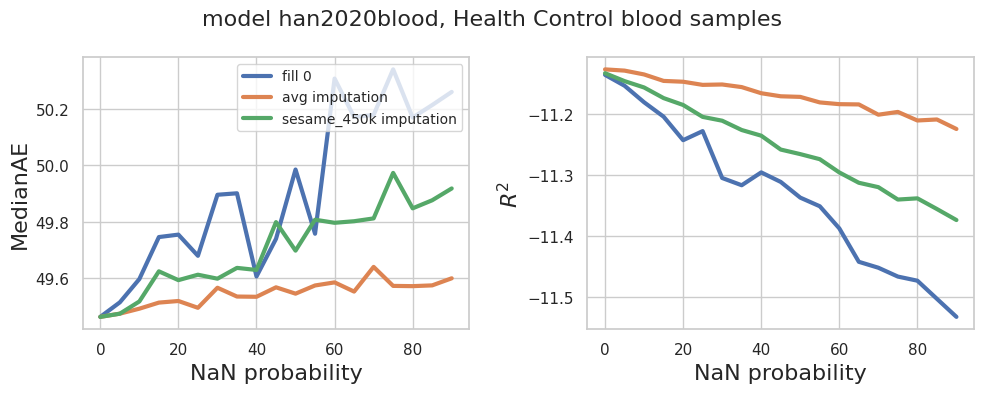

In [41]:
modelsnames = ['hrsinchphenoage',
 'lin2016blood_99cpgs',
 'yingdamage',
 'yingadaptage',
 'hannum2013blood',
 #'dec2023encen100', it is not aligible to our dataset, 
 #because it was trained for 100+ age
 'yingcausage',
 'horvath2018',
 'vidal-bralo2016blood',
 'lin2016blood_3cpgs',
 #'zhangblup2019',toooo large model, hard to calculation
 'zhangenclock2019',
 'phenoage2018',
 'dec2023encen40', 
'horvath2018', 'horvath2013_shrunken', 'horvath2013', 'han2020blood']


for mymodel in modelsnames:
    print(mymodel)
    plot_imputation(mymodel)
    # except Exception:
    #     print(Exception)    

## All models
## Объединенный вариант

In [42]:

#table_mae = pd.DataFrame(columns=['mae_0','mae_avg','mae_ses'])
#table_r2 = pd.DataFrame(columns=['r2_0', 'r2_avg', 'r2_ses'])
mae_0_list = []
mae_avg_list = []
mae_ses_list = []
r2_0_list = []
r2_avg_list = []
r2_ses_list = []

def medae_r2_all(X,y,mname):
    mae_0, r2_0= medae_r2(X, y, LinearMethylationModel(name=mname))
    mae_avg, r2_avg = medae_r2(X, y, LinearMethylationModel(name=mname, imputation='average'))
    mae_ses, r2_ses = medae_r2(X, y, LinearMethylationModel(name=mname, imputation="sesame_450k"))



    mae_0_list.append(pd.DataFrame(mae_0))
    mae_avg_list.append(pd.DataFrame(mae_avg))
    mae_ses_list.append(pd.DataFrame(mae_ses))

    r2_0_list.append(pd.DataFrame(r2_0))
    r2_avg_list.append(pd.DataFrame(r2_avg))
    r2_ses_list.append(pd.DataFrame(r2_ses))
    #return mae_avg, r2_avg

for mname in modelsnames:
    print(mname)
    medae_r2_all(data, y, mname=mname)

table_mae0 = pd.concat(mae_0_list, axis=1, join='outer', ignore_index=True)
table_maeavg = pd.concat(mae_avg_list, axis=1, join='outer', ignore_index=True)
table_maeses = pd.concat(mae_ses_list, axis=1, join='outer', ignore_index=True)


table_r20 = pd.concat(r2_0_list, axis=1, join='outer', ignore_index=True)
table_r2_avg = pd.concat(r2_avg_list, axis=1, join='outer', ignore_index=True)
table_r2_ses = pd.concat(r2_ses_list, axis=1, join='outer', ignore_index=True)
#######
# dfm = general.melt('actual age', var_name='modelname', value_name='prediction')

# fig, ax = plt.subplots(figsize = (10, 10))
# sns.set_theme(style="whitegrid")
# sns.lineplot(data=dfm, y='prediction', x = 'actual age', hue='modelname' , style='modelname',err_style="bars", errorbar=("se", 1))

#####




hrsinchphenoage
lin2016blood_99cpgs
yingdamage
yingadaptage
hannum2013blood
yingcausage
horvath2018
vidal-bralo2016blood
lin2016blood_3cpgs
zhangenclock2019
phenoage2018
dec2023encen40
horvath2018
horvath2013_shrunken
horvath2013
han2020blood


In [43]:
tables = [table_mae0, table_maeavg, table_maeses, table_r20, table_r2_avg, table_r2_ses]
tempi = 't'
for table in tables:
    
    table.columns = modelsnames
    table['prob100'] = nan_pct*100
    table.to_csv('imputation_tables/'+ tempi+'.csv', sep = '\t', index=False )

    tempi+='t'



In [44]:
table_mae0.head()
dfm_mae0 = table_mae0.melt('prob100', var_name='modelname', value_name='MedAE, fill 0')
dfm_mae0.head()

,prob100,modelname,"MedAE, fill 0"
0,0.0,hrsinchphenoage,8.921303
1,5.0,hrsinchphenoage,10.089090
2,10.0,hrsinchphenoage,10.645869
3,15.0,hrsinchphenoage,11.380036
4,20.0,hrsinchphenoage,12.612344


In [45]:
dfm_r20 = table_r20.melt('prob100', var_name='modelname', value_name='r2, fill 0')
dfm_r20.head()

,prob100,modelname,"r2, fill 0"
0,0.0,hrsinchphenoage,0.285295
1,5.0,hrsinchphenoage,0.017077
2,10.0,hrsinchphenoage,-0.173235
3,15.0,hrsinchphenoage,-0.364194
4,20.0,hrsinchphenoage,-0.435494


In [46]:
table_maeavg.head()
dfm_maeavg = table_maeavg.melt('prob100', var_name='modelname', value_name='MedAE, imputation with average')
dfm_maeavg.head()

,prob100,modelname,"MedAE, imputation with average"
0,0.0,hrsinchphenoage,8.243389
1,5.0,hrsinchphenoage,7.925166
2,10.0,hrsinchphenoage,7.373782
3,15.0,hrsinchphenoage,7.118685
4,20.0,hrsinchphenoage,6.950128


In [47]:
dfm_r2avg = table_r2_avg.melt('prob100', var_name='modelname', value_name='r2, imputation with average')
dfm_r2avg.head()

,prob100,modelname,"r2, imputation with average"
0,0.0,hrsinchphenoage,0.335657
1,5.0,hrsinchphenoage,0.391432
2,10.0,hrsinchphenoage,0.451322
3,15.0,hrsinchphenoage,0.492697
4,20.0,hrsinchphenoage,0.531047


In [48]:
dfm_maeses = table_maeses.melt('prob100', var_name='modelname', value_name='MedAE, imputation with sesame450k')
dfm_maeses.head()


,prob100,modelname,"MedAE, imputation with sesame450k"
0,0.0,hrsinchphenoage,8.479701
1,5.0,hrsinchphenoage,8.296113
2,10.0,hrsinchphenoage,7.745761
3,15.0,hrsinchphenoage,7.802438
4,20.0,hrsinchphenoage,7.708509


In [49]:
dfm_r2ses = table_r2_ses.melt('prob100', var_name='modelname', value_name='r2, imputation with sesame450k')
dfm_r2ses.head()

,prob100,modelname,"r2, imputation with sesame450k"
0,0.0,hrsinchphenoage,0.262165
1,5.0,hrsinchphenoage,0.318403
2,10.0,hrsinchphenoage,0.372225
3,15.0,hrsinchphenoage,0.389956
4,20.0,hrsinchphenoage,0.432156


In [50]:
tables_mae = dfm_mae0.copy()
tables_mae['average'] = dfm_maeavg['MedAE, imputation with average']
tables_mae['sesame'] = dfm_maeses['MedAE, imputation with sesame450k']

tables_r2 = dfm_r20.copy()
tables_r2['average'] = dfm_r2avg['r2, imputation with average']
tables_r2['sesame'] = dfm_r2ses['r2, imputation with sesame450k']


In [51]:
tables_mae = tables_mae.drop('modelname', axis=1)
tables_r2 = tables_r2.drop('modelname', axis=1)

In [52]:
tables_mae

,prob100,"MedAE, fill 0",average,sesame
0,0.0,8.921303,8.243389,8.479701
1,5.0,10.089090,7.925166,8.296113
2,10.0,10.645869,7.373782,7.745761
3,15.0,11.380036,7.118685,7.802438
4,20.0,12.612344,6.950128,7.708509
...,...,...,...,...
299,70.0,50.430943,49.538832,49.885188
300,75.0,50.411449,49.511014,49.870726
301,80.0,50.162964,49.583677,49.891403
302,85.0,50.463417,49.524519,50.002013


In [53]:
dfm_mae_all = tables_mae.melt('prob100', var_name='imputation type', value_name='MedAE')
dfm_r2_all = tables_r2.melt('prob100', var_name='imputation type', value_name='R^2')

In [54]:
dfm_mae_no0 = dfm_mae_all[dfm_mae_all['imputation type']!='MedAE, fill 0']
dfm_mae_no0

,prob100,imputation type,MedAE
304,0.0,average,8.243389
305,5.0,average,7.925166
306,10.0,average,7.373782
307,15.0,average,7.118685
308,20.0,average,6.950128
...,...,...,...
907,70.0,sesame,49.885188
908,75.0,sesame,49.870726
909,80.0,sesame,49.891403
910,85.0,sesame,50.002013


In [55]:
dfm_r2_no0 = dfm_r2_all[dfm_r2_all['imputation type']!='r2, fill 0']

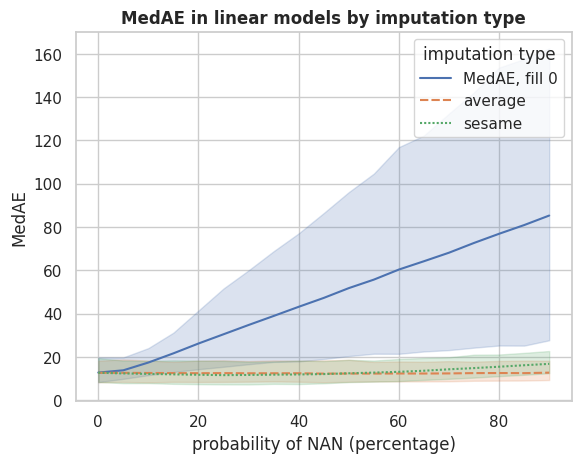

In [56]:
sns.set_theme(style="whitegrid")
ax = sns.lineplot(data=dfm_mae_all, y='MedAE', x = 'prob100', hue='imputation type' , style='imputation type')

    # ax[0].set_xlabel('NaN probability', fontsize=16)
    # ax[1].set_xlabel('NaN probability', fontsize=16)
    # ax[0].set_ylabel('MedianAE', fontsize=16)
    # ax[1].set_ylabel('$R^2$', fontsize=16)
    # ax[0].legend(fontsize=10, loc='upper right')
    # #ax[1].set_ylim([-0.5, 1.0])
    # plt.tight_layout()

ax.set_ylabel('MedAE')
ax.set_xlabel('probability of NAN (percentage)')
ax.set_title('MedAE in linear models by imputation type', weight='bold')

plt.savefig(f'figures/medae_impfig.png')
plt.show()

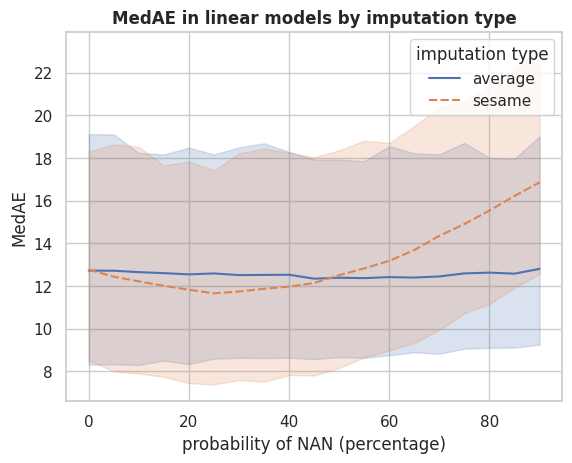

In [57]:
sns.set_theme(style="whitegrid")
ax = sns.lineplot(data=dfm_mae_no0, y='MedAE', x = 'prob100', hue='imputation type' , style='imputation type')

    # ax[0].set_xlabel('NaN probability', fontsize=16)
    # ax[1].set_xlabel('NaN probability', fontsize=16)
    # ax[0].set_ylabel('MedianAE', fontsize=16)
    # ax[1].set_ylabel('$R^2$', fontsize=16)
    # ax[0].legend(fontsize=10, loc='upper right')
    # #ax[1].set_ylim([-0.5, 1.0])
    # plt.tight_layout()

ax.set_ylabel('MedAE')
ax.set_xlabel('probability of NAN (percentage)')
ax.set_title('MedAE in linear models by imputation type', weight='bold')

plt.savefig(f'figures/medae_impfig0.png')
plt.show()

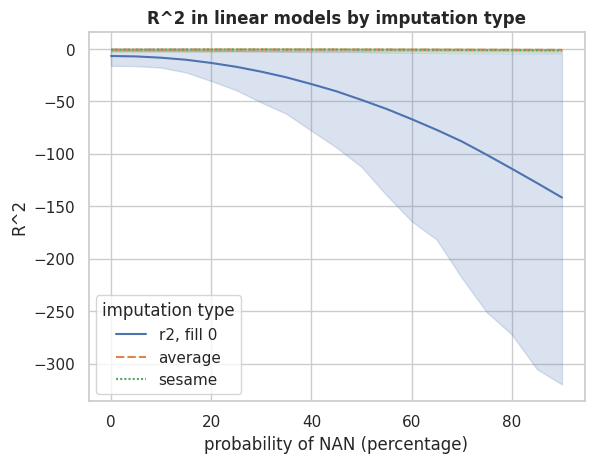

In [58]:
sns.set_theme(style="whitegrid")
ax = sns.lineplot(data=dfm_r2_all, y='R^2', x = 'prob100', hue='imputation type' , style='imputation type')

    # ax[0].set_xlabel('NaN probability', fontsize=16)
    # ax[1].set_xlabel('NaN probability', fontsize=16)
    # ax[0].set_ylabel('MedianAE', fontsize=16)
    # ax[1].set_ylabel('$R^2$', fontsize=16)
    # ax[0].legend(fontsize=10, loc='upper right')
    # #ax[1].set_ylim([-0.5, 1.0])
    # plt.tight_layout()

ax.set_ylabel('R^2')
ax.set_xlabel('probability of NAN (percentage)')
ax.set_title('R^2 in linear models by imputation type', weight='bold')

plt.savefig(f'figures/r2_impfig.png')
plt.show()

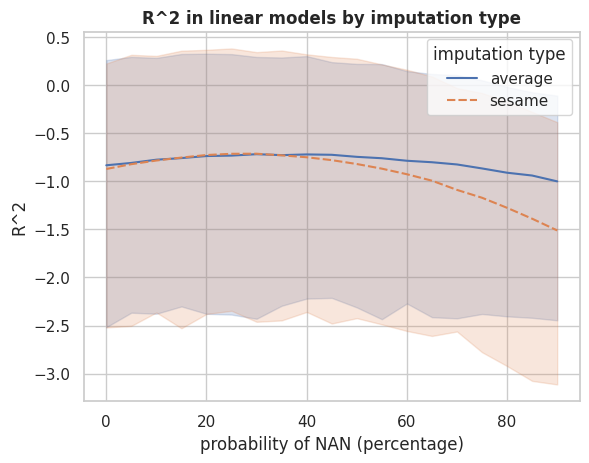

In [59]:
sns.set_theme(style="whitegrid")
ax = sns.lineplot(data=dfm_r2_no0, y='R^2', x = 'prob100', hue='imputation type' , style='imputation type')

    # ax[0].set_xlabel('NaN probability', fontsize=16)
    # ax[1].set_xlabel('NaN probability', fontsize=16)
    # ax[0].set_ylabel('MedianAE', fontsize=16)
    # ax[1].set_ylabel('$R^2$', fontsize=16)
    # ax[0].legend(fontsize=10, loc='upper right')
    # #ax[1].set_ylim([-0.5, 1.0])
    # plt.tight_layout()

ax.set_ylabel('R^2')
ax.set_xlabel('probability of NAN (percentage)')
ax.set_title('R^2 in linear models by imputation type', weight='bold')

plt.savefig(f'figures/r2no0_impfig.png')
plt.show()